## Working with Images

In this tutorial we'll provide an overview of the concepts and classes that 
represent medical images in the imfusion-sdk and how to work with them.

In [10]:
import imfusion
import imfusion.machinelearning as ml
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import IntSlider, interact, fixed

from imfusion_sdk.demo_utils import unzip_folder, mpr_plot

unzipped_folder = unzip_folder('data/pet-ct-rtstruct.zip')

### Image classes

- `SharedImage`: class holding a single image, can be a 2d Image (X-Ray, Ultrasound) or a 3d (CT, NM, MR, ...) volume. The word "Shared" refers to the fact that it can have multiple representation on different devices (typically CPU + GPU via OpenGL) which are kept automatically in sync.
- `SharedImageSet`: A Set of SharedImage. This is the main entry point of any method in the ImFusion SDK which operates on image data. For volumetric data, a SharedImageSet mostly comprises a single SharedImage representing a volume (i.e. a CT), but it is fundamental for holding image series consisting of multiple frame, which have no trivial 3d representation, i.e. an ultrasound acquisition, an OCT pullback, a Fluoro navigation, a 4D-CT and so on..
- `ImageDescriptor`: class describing the basic properties of the image, like its storage type (int, float, ...), its spacing, its shape.
- `Matrix`: orientation of the image data in the physical world

### Loading Images
- Since ImFusion files (.imf) can hold several SharedImageSets, loading an `.imf` file returns a list of `SharedImageSets`
- A `SharedImageSet` behaves like a list. You can iterate over it or index individual elements

In [11]:
pet, *_ = imfusion.load('data/pet-ct-rtstruct/pet')
labels, *_ = imfusion.load('data/pet-ct-rtstruct/tumors.imf')

print('PET: ', pet)
print('Labels: ', labels)

# The loaded SharedImageSets each contain one images.
print(f'Num of images in PET: {len(pet)}, num of images in Labels: {len(labels)}')

# Get SharedImage from SharedImageSet
image = pet[0]
print('SharedImage:', image)

[DICOM] Detected different rescale values per frame, rescale will be burned into pixel data!
PET:  imfusion.SharedImageSet(size: 1, [imfusion.SharedImage(FLOAT width: 192 height: 192 slices: 227 spacing: 3.64583x3.64583x3.27 mm)])
Labels:  imfusion.SharedImageSet(size: 1, [imfusion.SharedImage(UBYTE width: 192 height: 192 slices: 227 spacing: 3.64583x3.64583x3.27 mm)])
Num of images in PET: 1, num of images in Labels: 1
SharedImage: imfusion.SharedImage(FLOAT width: 192 height: 192 slices: 227 spacing: 3.64583x3.64583x3.27 mm)
[DICOM] Detected frame with shift/scale pair which exceeds the value range. Casting all frames to Float.


In [12]:
interact(
    mpr_plot,
    image=fixed(image),
    labels=fixed(labels[0]),
    x=IntSlider(112, 0, 191),
    y=IntSlider(104, 0, 191),
    z=IntSlider(195, 0, 226),
    continuous_update=False,
    vmin=0,
    vmax=30000,
    label_alpha=0.5
)
None

interactive(children=(IntSlider(value=112, description='x', max=191), IntSlider(value=104, description='y', ma…

The ImageDescriptor describes the basic properties of the images.
Each SharedImage also contains the modality information of its content.

In [13]:
print(image.descriptor, '\n')
print(image.modality)
print(labels[0].modality)

imfusion.ImageDescriptor(dimensions: [w:192, h:192, s:227, c:1] | spacing:[3.64583, 3.64583, 3.27] | isMetric:true | type:FLOAT | memory: 31.92 MB) 

Modality.NM
Modality.LABEL


### Accessing image data with numpy

The imfusion-sdk package provides interoperability with numpy arrays. SharedImage and SharedImageSet can be converted to numpy arrays and the other way around.

The shape of a SharedImage is: [slices, width, height, channels].

(227, 192, 192, 1)


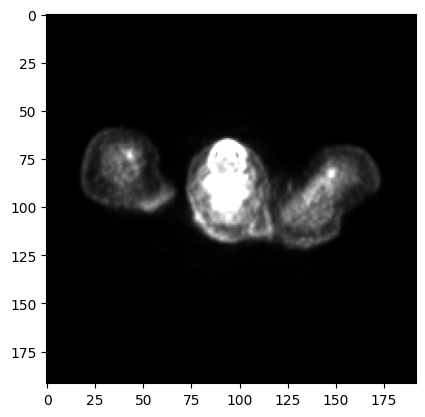

In [14]:
pet_image = pet.clone()[0]
array = np.array(pet_image)
print(pet_image.shape)

# select one slice for plotting
plt.imshow(array[200, :, :, :], cmap='gray', vmin=0, vmax=7500)
plt.show()

Since a SharedImageSet is basically a list of SharedImage, it has an additional dimension and the array shape is:
[frames, slices, height, width, channels]

In [15]:
array_set = np.array(pet, copy=False)
print(array_set.shape)

(1, 227, 192, 192, 1)


#### Create SharedImage/SharedImageSets from numpy arrays

In [16]:
# SharedImage can be constructed from a rank-4 np.array
array = np.ones((1, 32, 32, 1), dtype=int)
new_image = imfusion.SharedImage(array)
new_set = imfusion.SharedImageSet(new_image)
print(new_set)

# SharedImageSet can be constructed from a rank-5 np.array
array = np.ones((1, 1, 32, 32, 1), dtype=int)
new_sis = imfusion.SharedImageSet(array)
print(new_set)

imfusion.SharedImageSet(size: 1, [imfusion.SharedImage(DOUBLE width: 32 height: 32)])
imfusion.SharedImageSet(size: 1, [imfusion.SharedImage(DOUBLE width: 32 height: 32)])


#### Modifying image data
- np.array() creates a copy by default. Every change to the array is therefore not propagated to the SharedImage.
- To update the SharedImage we have to copy the changed data back into the SharedImage using `assign_array()`.

Note: You cannot resize or reshape the image in this way, nor change the type of the image. In such cases you need to create a new image from the modified numpy array.

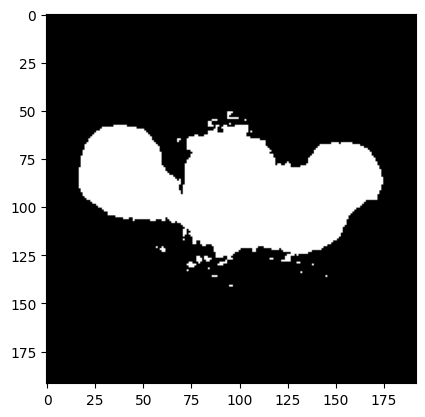

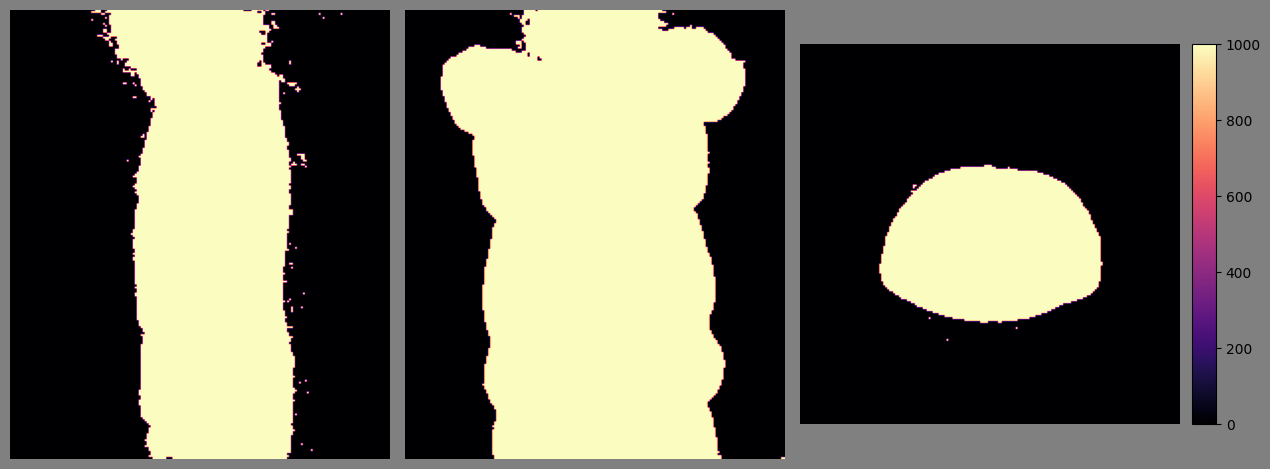

In [17]:
# Create mask by thresholding
array = np.array(pet_image, copy=False)

threshold = 100
array[array < threshold] = 0
array[array >= threshold] = 1000

plt.imshow(array[200, :, :, :], cmap='gray')
plt.show()
pet_image.assign_array(array)
mpr_plot(pet_image)

### Save Images
A list of SharedImageSets can be saved to disk again ...and then visualized in the ImFusion Suite

In [18]:
# The generic `imfusion.save` method saves file to ImFusion files, which end with `.imf`
imfusion.save([pet], 'data/thresholded_pet.imf')

### DICOM IO
The imfusion-sdk can also load DICOM files and folders and save specifically to DICOM format via a dedicated submodule called `imfusion.dicom`
The module offers some extra IO routines specific to DICOM. For example IO from/to DICOM RTStructuredSet and DICOM Seg.

#### DICOM-RTStructure file IO
The following code shows how to load a DICOM RTStructure file and convert it to a labelmap (or binary mask).

In [19]:
rtstructs = imfusion.load('data/pet-ct-rtstruct/uterus-rtstruct/1-1.dcm')

# rtstructs are represented as PointClouds
print("rtstruct", rtstructs)

# Convert them to labelmaps, by default each different set is converted to a separate mask
# Each mask has pixel value specified by the rtstruct label tag and some background 
mask, *_ = imfusion.dicom.rtstruct_to_labelmap(rtstructs, pet)
print("mask", mask)

# Access the LabelDataComponent to get more information about the specific mask
ldc = mask.components.label
print(ldc.label_configs())

ldc = mask.components.label
print(ldc)
ldc.remove_label(0)  # we don't care about the background here
print(ldc)
label_name = list(ldc.label_configs().values())[0].name
print(label_name)
tumor_mask = mask

assert tumor_mask is not None

rtstruct [<imfusion._bindings.PointCloud object at 0x7f2eac177270>]
mask imfusion.SharedImageSet(size: 1, [imfusion.SharedImage(UBYTE width: 192 height: 192 slices: 227 spacing: 3.64583x3.64583x3.27 mm)])
{0: LabelConfig(name="Background", color=(0.00, 0.00, 0.00, 1.00)), 1: LabelConfig(name="UTERUS - 1", color=(1.00, 1.00, 0.00, 1.00))}
<LabelDataComponent
	0: LabelConfig(name="Background", color=(0.00, 0.00, 0.00, 1.00))
	1: LabelConfig(name="UTERUS - 1", color=(1.00, 1.00, 0.00, 1.00))
>
<LabelDataComponent 1: LabelConfig(name="UTERUS - 1", color=(1.00, 1.00, 0.00, 1.00))>
UTERUS - 1


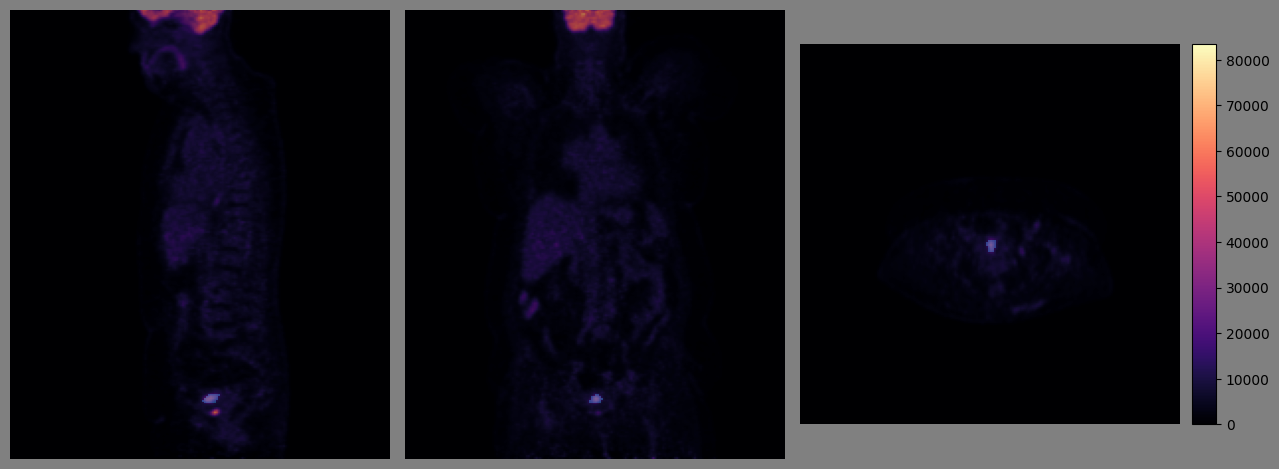

In [20]:
mpr_plot(pet[0], labels=tumor_mask[0], y=100, z=195)

Saving a mask as RTStruct

In [21]:
# Here we apply a dilation just to obtain a slightly different mask than the one we loaded
dilated_mask = ml.MorphologicalFilterOperation(mode='dilation', op_size=1, use_l1_distance=True).process(
    tumor_mask)  # dilate by 1 voxel

# save to rtstruct
imfusion.dicom.save_rtstruct(dilated_mask, pet, '../data/tumor_mask_dilated_rtstruct.dcm')

Saving a mask as DICOM Seg

In [22]:
imfusion.dicom.save_file(tumor_mask, 'data/tumor_mask_seg.dcm', referenced_image=pet)

# Now load it again
(tumor_mask_from_dcm_seg,) = imfusion.dicom.load_file('data/tumor_mask_seg.dcm')

# Check that we have the same orientation
assert np.allclose(tumor_mask_from_dcm_seg[0].matrix, tumor_mask[0].matrix)

# assert the data is now bit exactly the original tumor mask
assert np.allclose(tumor_mask_from_dcm_seg[0].numpy(), tumor_mask[0].numpy())
